# `breast_cancer` dataset

In [1]:
import os, sys, importlib.util

# 1) Where Jupyter is currently running:
cwd = os.getcwd()
print("Notebook cwd:", cwd)

# 2) Compute the folder above (your project root):
project_root = os.path.abspath(os.path.join(cwd, os.pardir))
print("Project root:", project_root)
print("→ Contains:", os.listdir(project_root))

# 3) Inject it onto sys.path (highest priority):
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("After hack, sys.path[0]:", sys.path[0])

# 4) Confirm Python can now see lmt_pkg:
print("After hack, spec(lmt_pkg):", importlib.util.find_spec("lmt_pkg"))

from lmt_pkg import lmt_final_implementation as lmt
from lmt_pkg import calibration_functions as calibration
from lmt_pkg import logitboost_j_implementation as logitboost

Notebook cwd: c:\Users\allis\Desktop\MITACS\LMT-calibration\Construction and tests
Project root: c:\Users\allis\Desktop\MITACS\LMT-calibration
→ Contains: ['.git', 'Calibration testing', 'Construction and tests', 'Documentation', 'lmt_pkg', 'Papers', 'README.md']
After hack, sys.path[0]: c:\Users\allis\Desktop\MITACS\LMT-calibration
After hack, spec(lmt_pkg): ModuleSpec(name='lmt_pkg', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000002419141C400>, origin='c:\\Users\\allis\\Desktop\\MITACS\\LMT-calibration\\lmt_pkg\\__init__.py', submodule_search_locations=['c:\\Users\\allis\\Desktop\\MITACS\\LMT-calibration\\lmt_pkg'])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

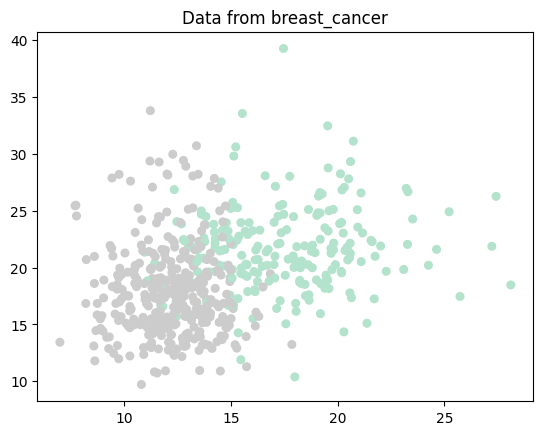

Shape of X2: (569, 30)
Shape of y2: (569,)


In [3]:
# Generate synthetic data using make_circles
#X, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=0)
# Testing
from sklearn.datasets import load_breast_cancer
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data   
y = data.target

plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Pastel2)    
plt.title("Data from breast_cancer")
plt.show()

print("Shape of X2:", X.shape)
print("Shape of y2:", y.shape)

In [4]:
# Split the dataset into training and testing sets
# For original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## LogitBoost for *J* classes algorithm

### For original dataset

In [5]:
# Fit the LogitBoost model
learners1, J1 = logitboost.logitboost_fit(X_train, y_train, n_estimators=500)

# Predict using the fitted model on test set
y_pred1 = logitboost.logitboost_predict(X_test, learners1, J1)
y_proba1 = logitboost.logitboost_predict_proba(X_test, learners1, J1)

# Evaluate the model
acc1 = accuracy_score(y_test, y_pred1)
roc1 = roc_auc_score(y_test, y_proba1[:, 1])
log_loss1 = log_loss(y_test, y_proba1)

# Print results for original make_circles
print(f"Log-loss on original make_circles: {log_loss1:.4f}")
print(f"Accuracy on original make_circles: {acc1:.4f}")
print(f"ROC AUC on original make_circles: {roc1:.4f}")

Log-loss on original make_circles: 0.2079
Accuracy on original make_circles: 0.9649
ROC AUC on original make_circles: 0.9934


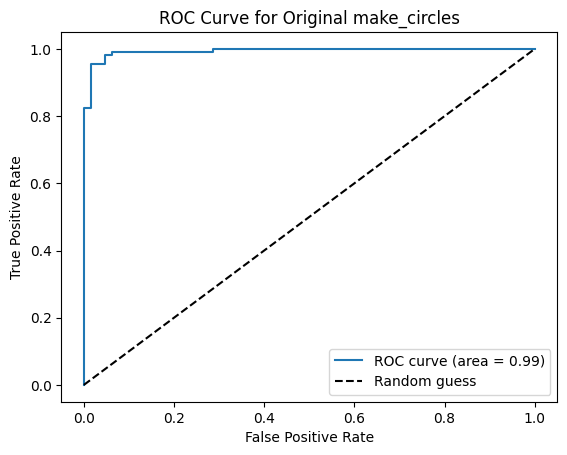

In [5]:
# Visualizations
# ROC curve for original make_circles
from sklearn.metrics import roc_curve
fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1])
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve (area = {:.2f})'.format(roc1))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Original make_circles')
plt.legend(loc='lower right')
plt.show()

### Calibration with *LogitBoost* for $J$ classes model

#### Calibration Curve
Calibration curves, also referred to as reliability diagrams, compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the frequency of the positive label (to be more precise, an estimation of the conditional event probability $P(Y=1 | \text{predict proba})$ ) on the y-axis against the predicted probability predict_proba of a model on the x-axis. The tricky part is to get values for the y-axis.

In [6]:
# ------------------------------------------------------------
# 1.  Get class-probability estimates for each model
# ------------------------------------------------------------
#  -> keep only the probability of the positive class (column 1)
proba_orig = logitboost.logitboost_predict_proba(X_test,     learners1, J1)[:, 1]

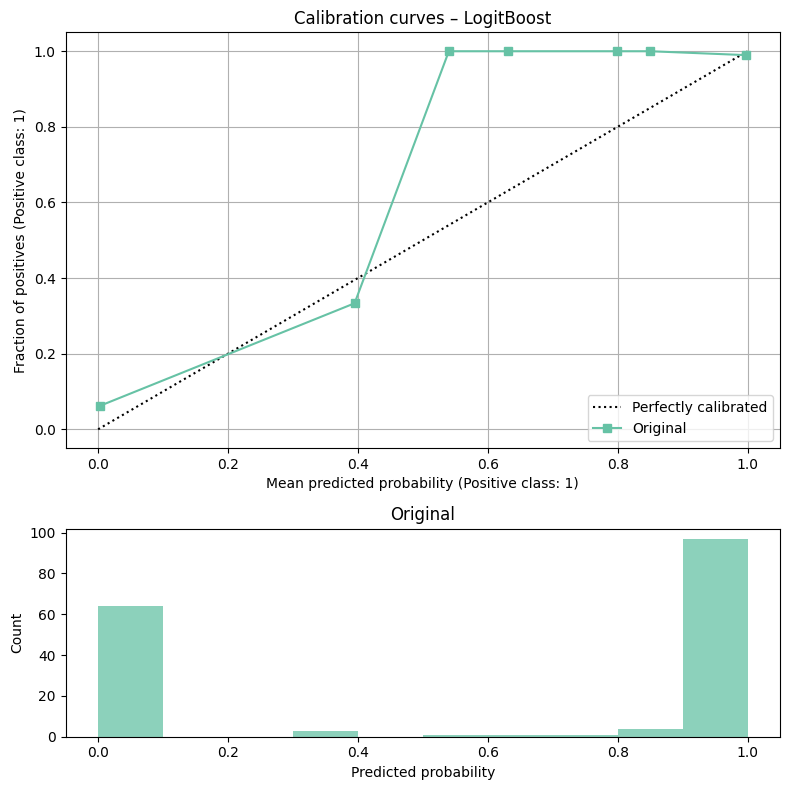

In [7]:
# ------------------------------------------------------------
# 2.  Draw calibration plots
# ------------------------------------------------------------
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs  = GridSpec(nrows=2, ncols=2, height_ratios=[2, 1])

ax_curve = fig.add_subplot(gs[0, :])                 # big panel for the curves
ax_hist1 = fig.add_subplot(gs[1, :])                 # histogram – model 1
colors   = plt.get_cmap("Set2")

# ―― Curve for the ORIGINAL data ――
CalibrationDisplay.from_predictions(
    y_test,           # true labels (binary, 0 / 1)
    proba_orig,       # predicted prob of class 1
    n_bins=10,
    name="Original",
    ax=ax_curve,
    color=colors(0),
)

ax_curve.set_title("Calibration curves – LogitBoost")
ax_curve.grid(True)

# ------------------------------------------------------------
# 3.  Add probability histograms (optional but informative)
# ------------------------------------------------------------
ax_hist1.hist(proba_orig, bins=10, range=(0, 1),
              color=colors(0), alpha=0.75)
ax_hist1.set(title="Original", xlabel="Predicted probability", ylabel="Count")

fig.tight_layout()
plt.show()


In [8]:
from collections import defaultdict
import pandas as pd
from sklearn.metrics import (
    brier_score_loss, log_loss, roc_auc_score,
    precision_score, recall_score, f1_score
)

models = [
    ("LogitBoost (original)", learners1, J1, X_test,     y_test),
]


# Gather all metrics in a dictionary
scores = defaultdict(list)

for name, learners, J, X_te, y_te in models:
    # Probability estimates of the positive class (column 1)
    y_prob = logitboost.logitboost_predict_proba(X_te, learners, J)[:, 1]
    # Hard predictions (labels)
    y_pred = logitboost.logitboost_predict(X_te, learners, J)
    
    scores["Classifier"].append(name)
    
    # Metrics that use probabilities
    for metric in (brier_score_loss, log_loss, roc_auc_score):
        col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[col].append(metric(y_te, y_prob))
    
    # Metrics that use hard predictions
    for metric in (precision_score, recall_score, f1_score):
        col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[col].append(metric(y_te, y_pred))


score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(3)
      .sort_index()
)

print(score_df)


                       Brier  loss  Log loss  Roc auc   Precision   Recall   \
Classifier                                                                    
LogitBoost (original)        0.034     0.208     0.993        0.99    0.954   

                         F1   
Classifier                    
LogitBoost (original)  0.972  


## Trees with $C4.5$ algorithm and different depth

In [9]:
import lmt_final_implementation as lmt
from sklearn import tree

### For the original dataset

In [10]:
def compare_tree_variants(X_train, X_test, y_train, y_test, lmt):
    """
    Trains and evaluates four logistic model trees using different sizes and pruning strategies.
    Plots the tree structure and prints evaluation metrics.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame or np.ndarray
        Training and test feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Training and test labels.
    lmt : module or object
        Module or object that provides the `construct_tree` method.
    """
    
    configs = [
        ('shallow', False, "Shallow Tree (No Pruning)"),
        ('regular', False, "Regular Tree (No Pruning)"),
        ('overfit', False, "Overfit Tree (No Pruning)"),
        ('regular', True,  "Regular Tree (With Pruning)")
    ]

    classifiers = []
    results = []

    # Tree construction
    for size, pruning, label in configs:
        clf = lmt.construct_tree(X_train, y_train, size=size, pruning=pruning)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        # Evaluation
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        loss = log_loss(y_test, clf.predict_proba(X_test))

        print(f"{label} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, Log Loss: {loss:.4f}")
        
        classifiers.append(clf)
        results.append((label, acc, auc, loss))

    # Plotting all four trees
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for ax, clf, (label, _, _, _) in zip(axes.ravel(), classifiers, results):
        tree.plot_tree(clf, filled=True, ax=ax, fontsize=8)
        ax.set_title(label, fontsize=14)

    plt.tight_layout()
    plt.show()

    # Plotting decision surfaces of all four trees
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    for ax, clf, (size, pruning, label) in zip(axes2.ravel(), classifiers, configs):
        lmt.plot_decision_surface_from_fitted_tree(
            clf_tree=clf,
            X=X_train,
            feature_pair=(0, 1),
            y=y_train,
            fixed_vals=None,
            grid_steps=200,
            cmap='RdYlBu',
            ax=ax,
            title=label
        )

    plt.tight_layout()
    plt.show()

Shallow Tree (No Pruning) - Accuracy: 0.8947, AUC: 0.9779, Log Loss: 0.1546
Regular Tree (No Pruning) - Accuracy: 0.9708, AUC: 0.9763, Log Loss: 0.6741
Overfit Tree (No Pruning) - Accuracy: 0.9591, AUC: 0.9511, Log Loss: 1.4755
Regular Tree (With Pruning) - Accuracy: 0.9649, AUC: 0.9752, Log Loss: 0.3236


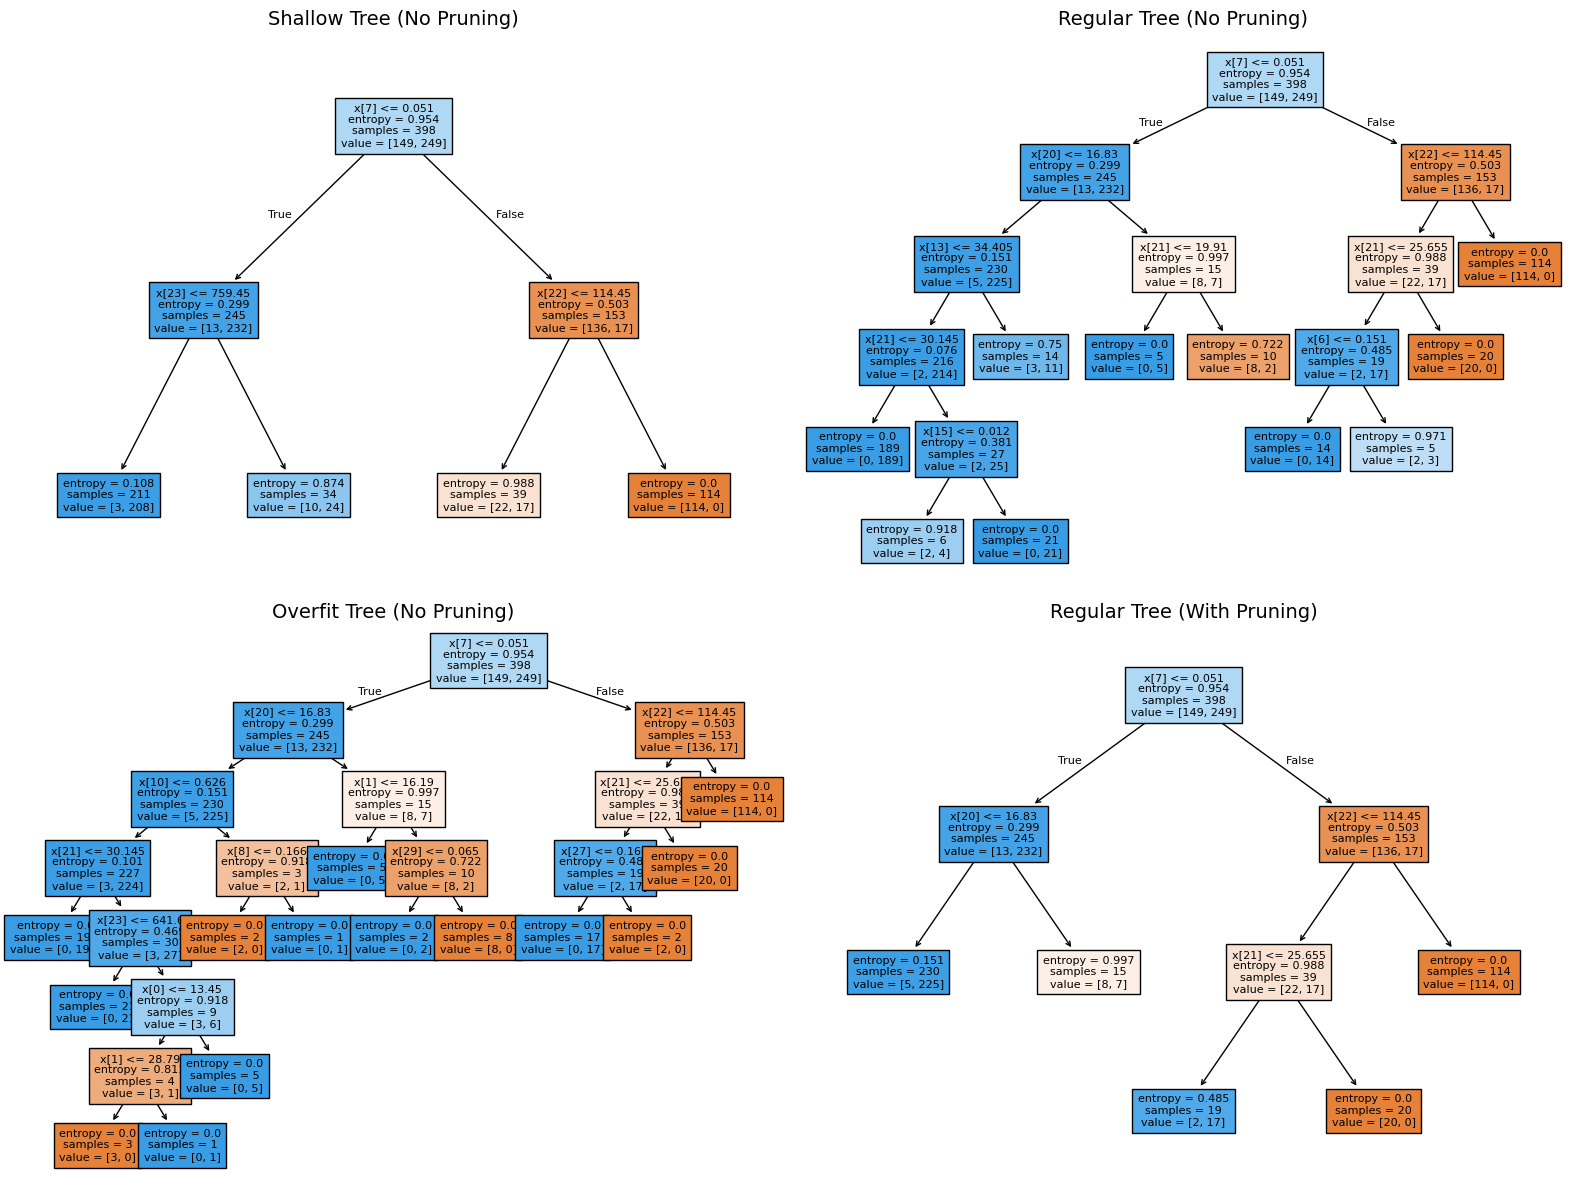

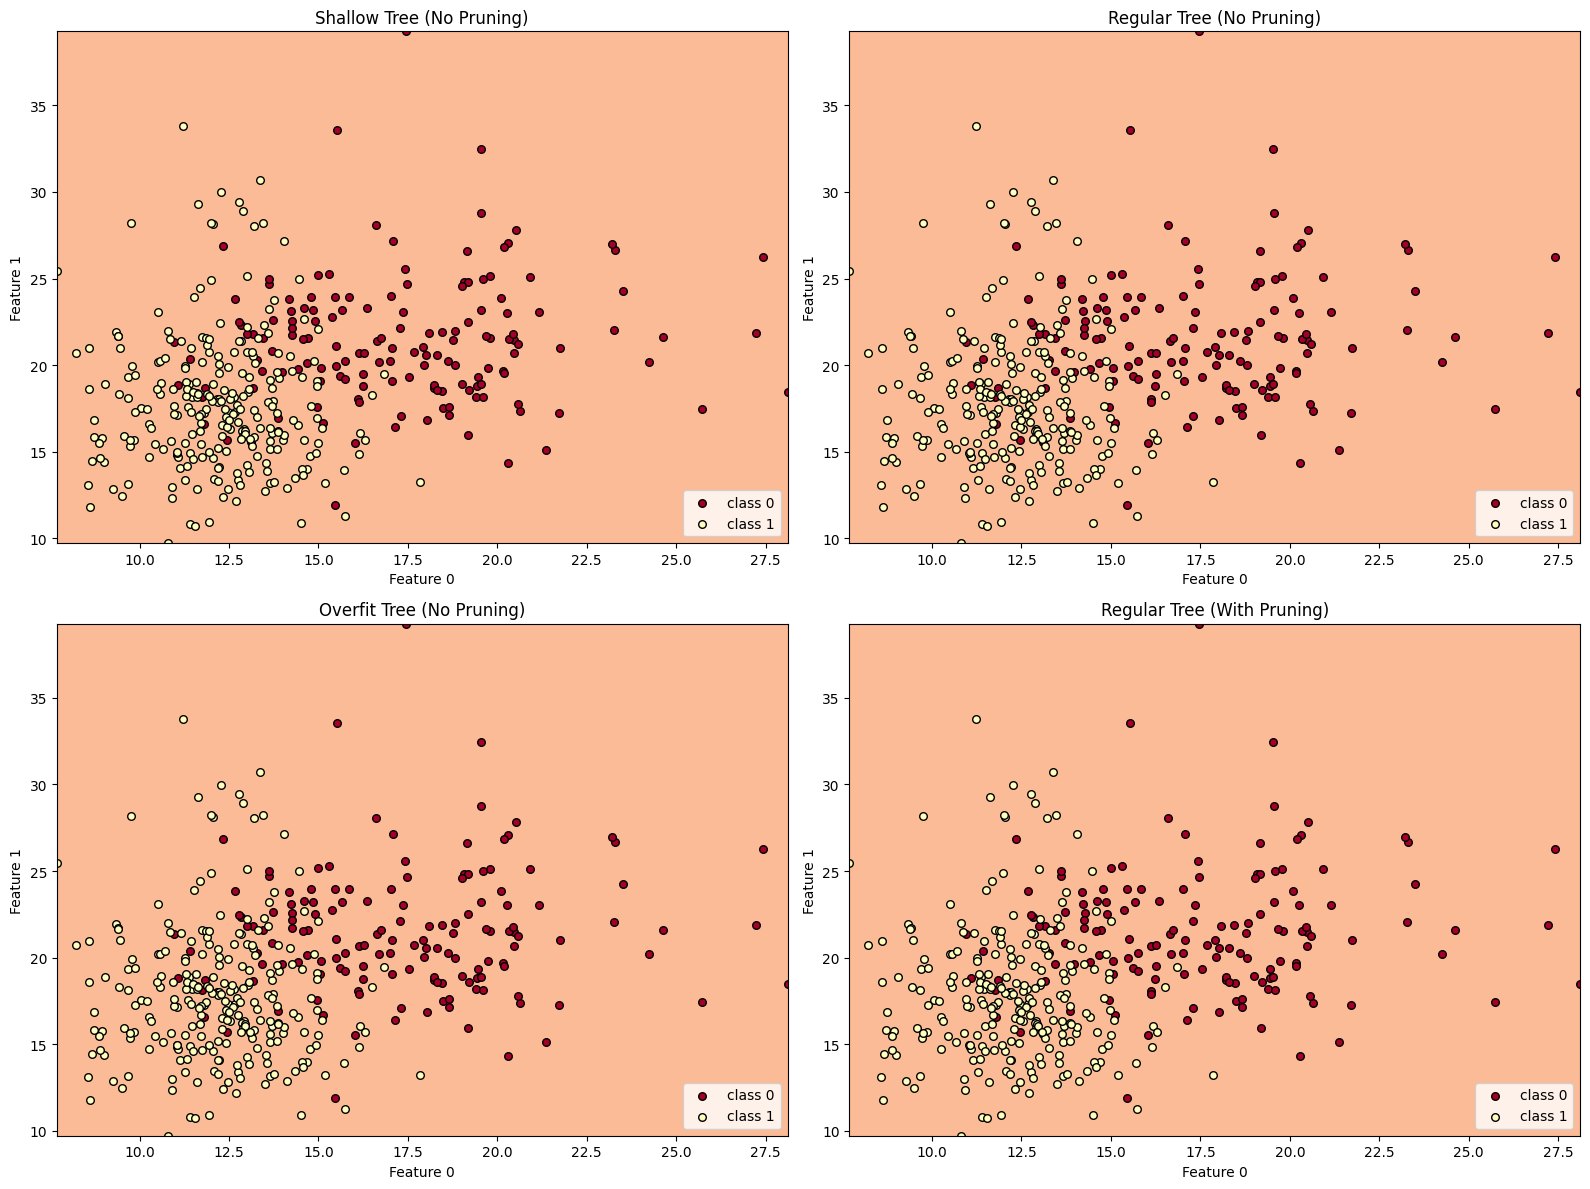

In [11]:
compare_tree_variants(X_train, X_test, y_train, y_test, lmt)

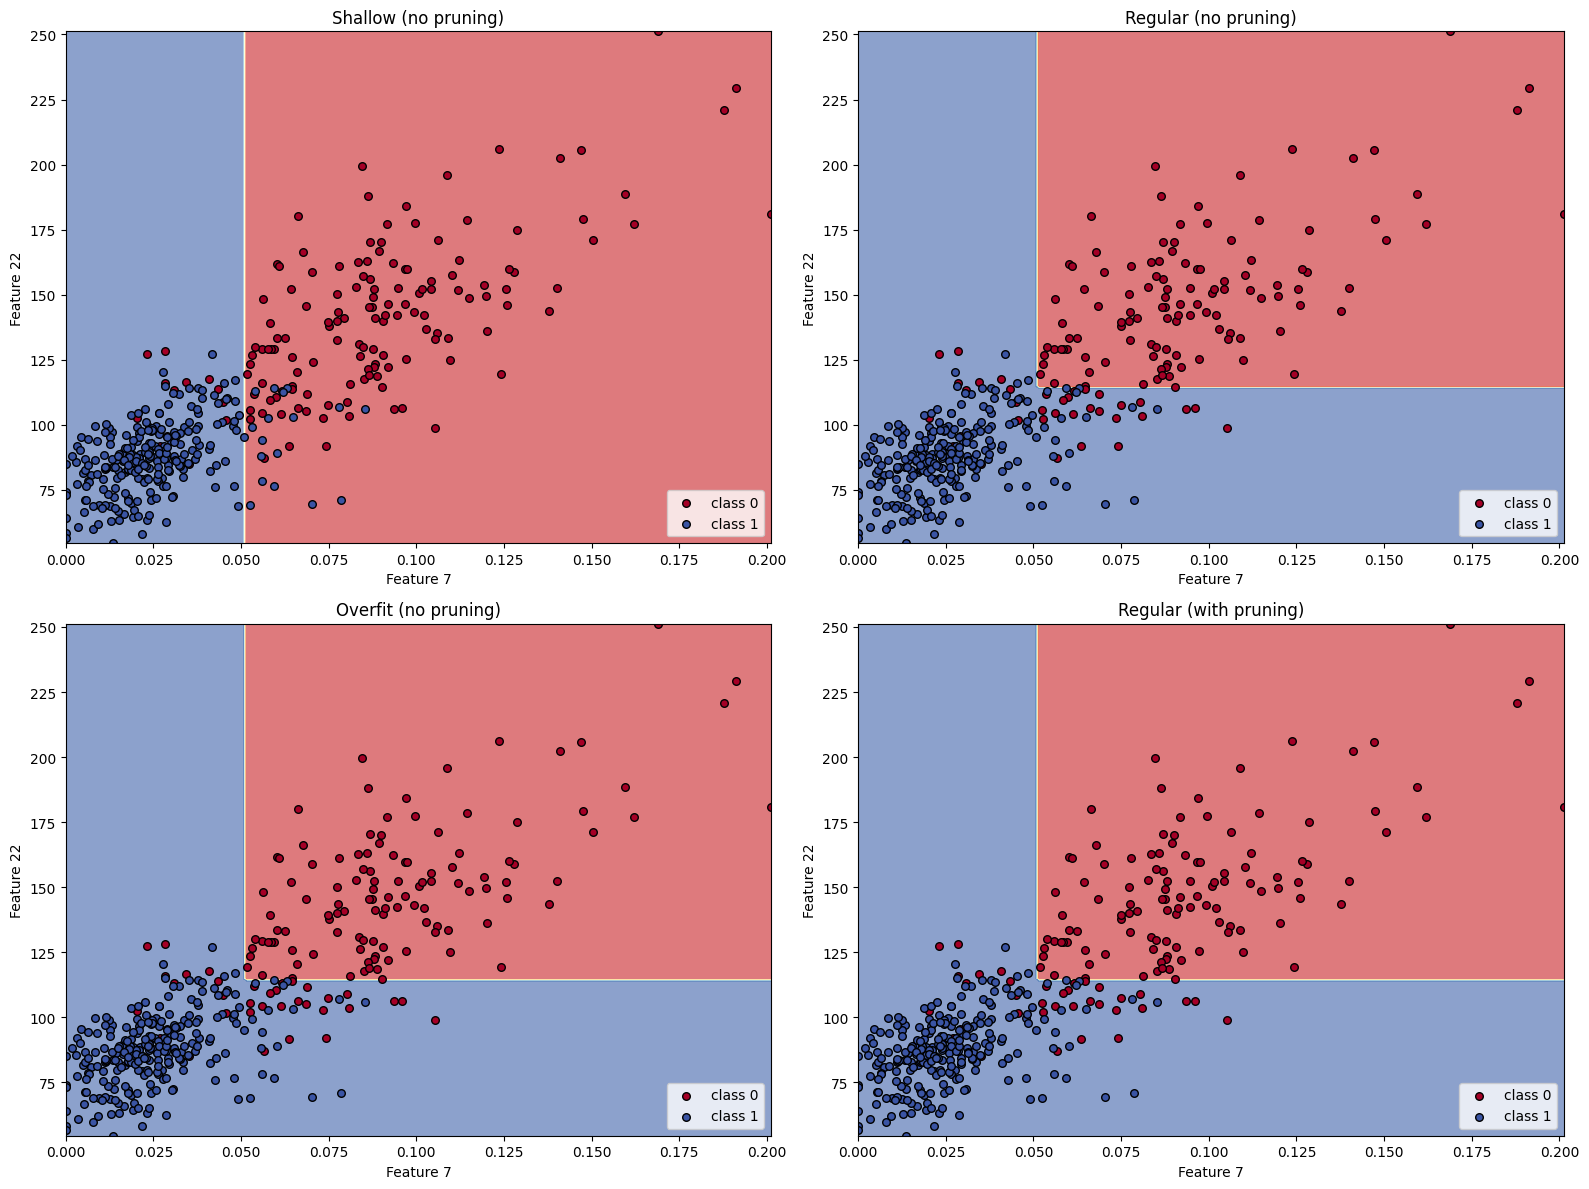

In [15]:
# Plotting decision surfaces of all four trees
clf_shallow = lmt.construct_tree(X_train, y_train, size='shallow', pruning=False)
clf_regular = lmt.construct_tree(X_train, y_train, size='regular', pruning=False)
clf_overfit = lmt.construct_tree(X_train, y_train, size='overfit', pruning=False)
clf_pruned = lmt.construct_tree(X_train, y_train, size='regular', pruning=True)


clfs       = [clf_shallow,     clf_regular,     clf_overfit,     clf_pruned]
titles     = [
    "Shallow (no pruning)",
    "Regular (no pruning)",
    "Overfit (no pruning)",
    "Regular (with pruning)"
]


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, clf, title in zip(axes.ravel(), clfs, titles):
    lmt.plot_decision_surface_from_fitted_tree(
        clf_tree=clf,
        X=X_train,
        feature_pair=(7, 22),  # adjust if you want different feature axes
        y=y_train,
        fixed_vals=None,
        grid_steps=200,
        cmap='RdYlBu',
        ax=ax,
        title=title
    )

plt.tight_layout()
plt.show()

### Calibration curves

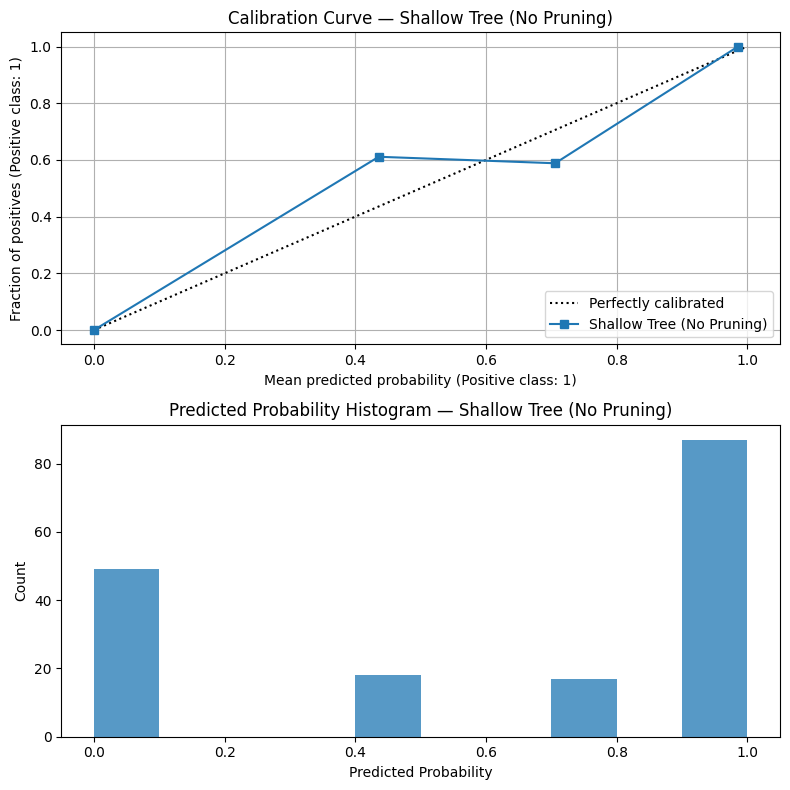

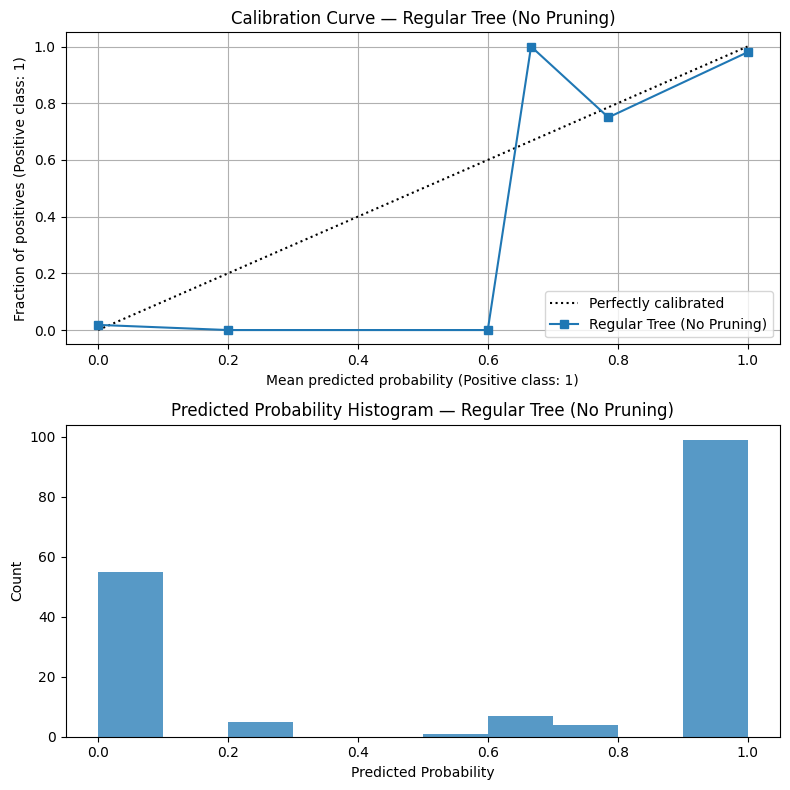

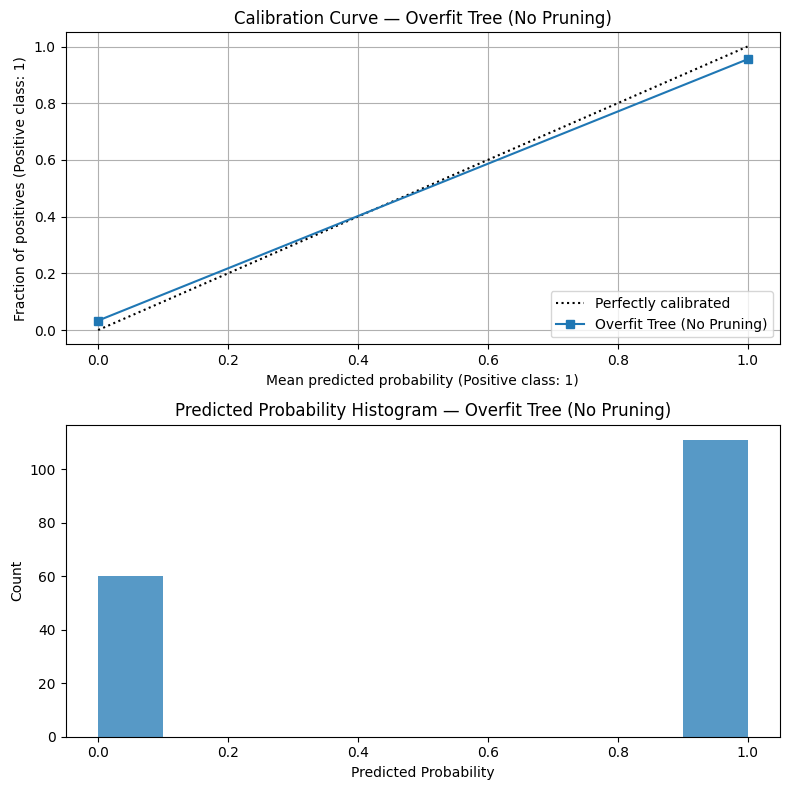

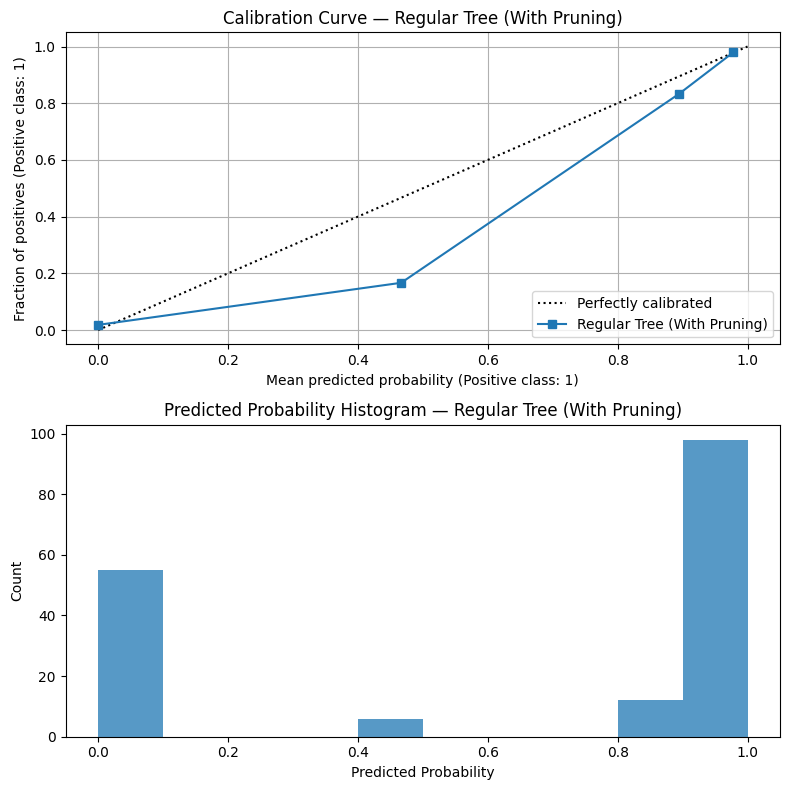

In [16]:
# 1) Define your four configurations
configs = [
    ('shallow', False, "Shallow Tree (No Pruning)"),
    ('regular', False, "Regular Tree (No Pruning)"),
    ('overfit', False, "Overfit Tree (No Pruning)"),
    ('regular', True,  "Regular Tree (With Pruning)")
]

# 2) Fit one clf per config and keep its label
clfs = [
    (
        label,
        lmt.construct_tree(X_train, y_train, size=size, pruning=pruning)
    )
    for size, pruning, label in configs
]

# 3) Loop and plot each calibration+histogram
for label, clf in clfs:
    fig, (ax_curve, ax_hist) = plt.subplots(2, 1, figsize=(8, 8))

    # Calibration curve
    CalibrationDisplay.from_estimator(
        clf,               # the trained tree
        X_test,            # test features
        y_test,            # true labels
        n_bins=10,         # number of calibration bins
        name=label,        # use the config label here
        ax=ax_curve
    )
    ax_curve.set_title(f"Calibration Curve — {label}")
    ax_curve.grid(True)

    # Probability histogram
    y_prob = clf.predict_proba(X_test)[:, 1]
    ax_hist.hist(y_prob, bins=10, range=(0, 1), alpha=0.75)
    ax_hist.set_title(f"Predicted Probability Histogram — {label}")
    ax_hist.set_xlabel("Predicted Probability")
    ax_hist.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


In [17]:
scores = defaultdict(list)

for label, clf in clfs:
    name   = f"{label} (original)"
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    scores["Classifier"].append(name)
    
    # Probabilistic metrics
    for metric in (brier_score_loss, log_loss, roc_auc_score):
        col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[col].append(metric(y_test, y_prob))
    
    # Discrete‐prediction metrics
    for metric in (precision_score, recall_score, f1_score):
        col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[col].append(metric(y_test, y_pred))

tree_score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(4)
      .sort_index()
)

print(tree_score_df)



                                        Brier  loss  Log loss  Roc auc   \
Classifier                                                                
Overfit Tree (No Pruning) (original)         0.0409    1.4755    0.9511   
Regular Tree (No Pruning) (original)         0.0298    0.6741    0.9763   
Regular Tree (With Pruning) (original)       0.0353    0.3236    0.9752   
Shallow Tree (No Pruning) (original)         0.0538    0.1546    0.9779   

                                        Precision   Recall      F1   
Classifier                                                           
Overfit Tree (No Pruning) (original)        0.9550   0.9815  0.9680  
Regular Tree (No Pruning) (original)        0.9640   0.9907  0.9772  
Regular Tree (With Pruning) (original)      0.9636   0.9815  0.9725  
Shallow Tree (No Pruning) (original)        0.9327   0.8981  0.9151  


## LMT implementation version with *SimpleLogistic* routine at every node

### For the original dataset

In [18]:
def compare_lmt_variants(X_train, X_test, y_train, y_test, lmt):
    """
    Trains and evaluates four logistic model trees using different sizes and pruning strategies.
    Plots the tree structure and prints evaluation metrics.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame or np.ndarray
        Training and test feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Training and test labels.
    lmt : module or object
        Module or object that provides the `construct_tree` method.
    """
    
    configs = [
        ('shallow', False, "Shallow Tree (No Pruning)"),
        ('regular', False, "Regular Tree (No Pruning)"),
        ('overfit', False, "Overfit Tree (No Pruning)"),
        ('regular', True,  "Regular Tree (With Pruning)")
    ]

    fitted = []

    # Tree construction
    for size, pruning, label in configs:
        clf_tree, node_models = lmt.fit_logistic_model_tree(X_train, y_train, size=size, pruning=pruning)
        # Hard predictions
        y_pred = lmt.predict_lmt(X_test, clf_tree, node_models)
        # extract per‐sample proba. of class 1
        y_prob = lmt.predict_proba_lmt(X_test, clf_tree, node_models)

        # 4) metrics
        acc  = accuracy_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_prob)
        loss = log_loss(y_test, y_prob)
        print(f"{label} → Accuracy: {acc:.4f}, AUC: {auc:.4f}, Log Loss: {loss:.4f}")
        
        fitted.append((clf_tree, node_models, label))

    # Plotting all four trees
    for clf_tree, node_models, label in fitted:
        plt.figure(figsize=(16, 8))
        lmt.plot_tree_with_linear_models(
            clf_tree, node_models,
            X=X_train,
            title=label
        )
        plt.tight_layout()
        plt.show()


    # Plotting decision surfaces of all four trees
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for ax, (clf_tree, _, label) in zip(axes.ravel(), fitted):
        lmt.plot_decision_surface_from_fitted_tree(
            clf_tree=clf_tree,
            X=X_train,
            feature_pair=(7, 22),
            y=y_train,
            fixed_vals=None,
            grid_steps=200,
            cmap='RdYlBu',
            ax=ax,
            title=label
        )
    plt.tight_layout()
    plt.show()




Shallow Tree (No Pruning) → Accuracy: 0.9415, AUC: 0.9882, Log Loss: 0.2229
Regular Tree (No Pruning) → Accuracy: 0.9649, AUC: 0.9791, Log Loss: 0.5392
Overfit Tree (No Pruning) → Accuracy: 0.9357, AUC: 0.9565, Log Loss: 1.1622
Regular Tree (With Pruning) → Accuracy: 0.9474, AUC: 0.9941, Log Loss: 0.2003


<Figure size 1600x800 with 0 Axes>

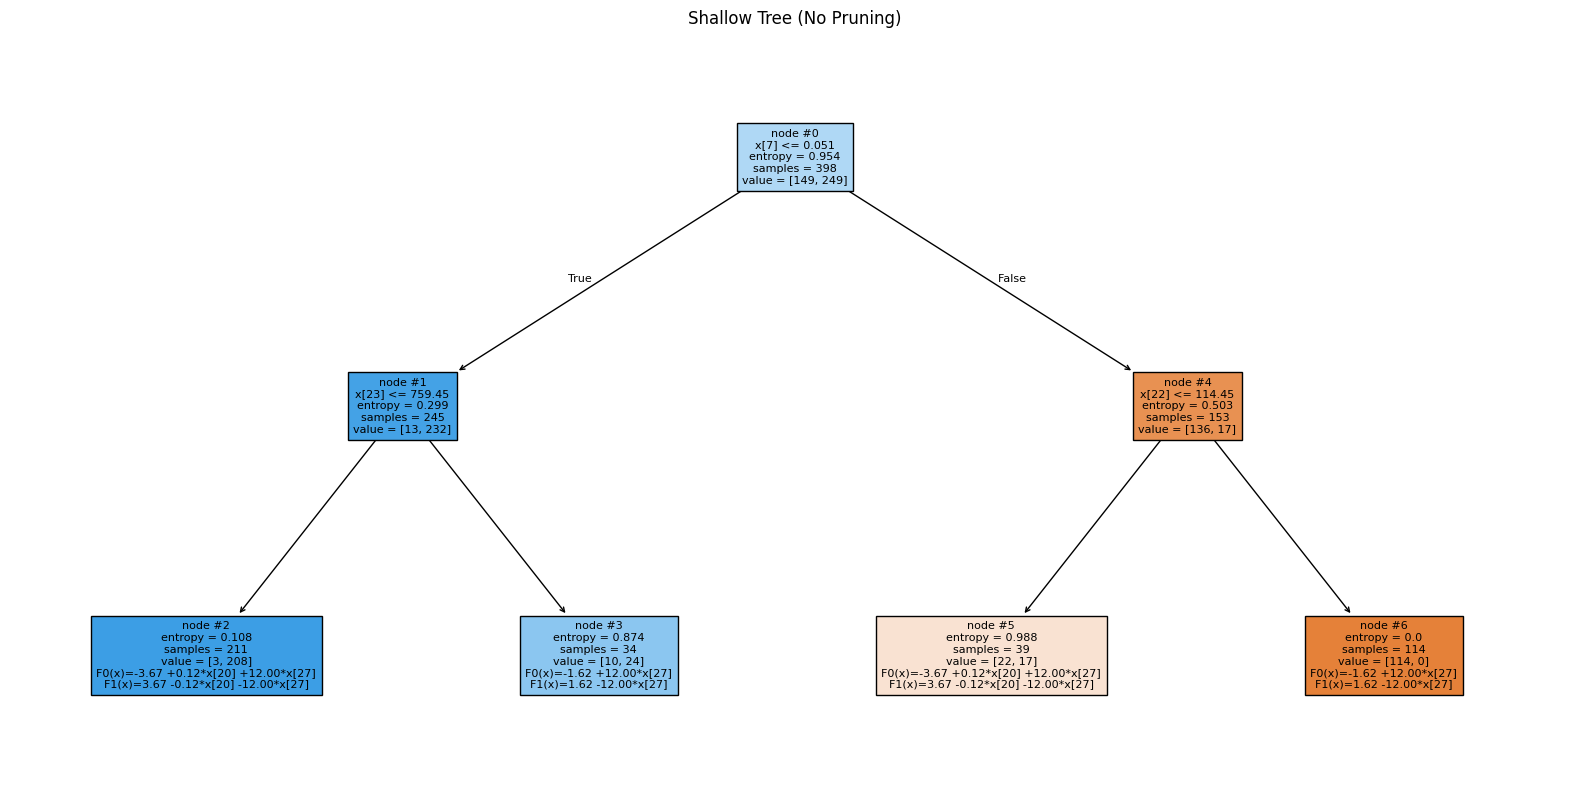

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

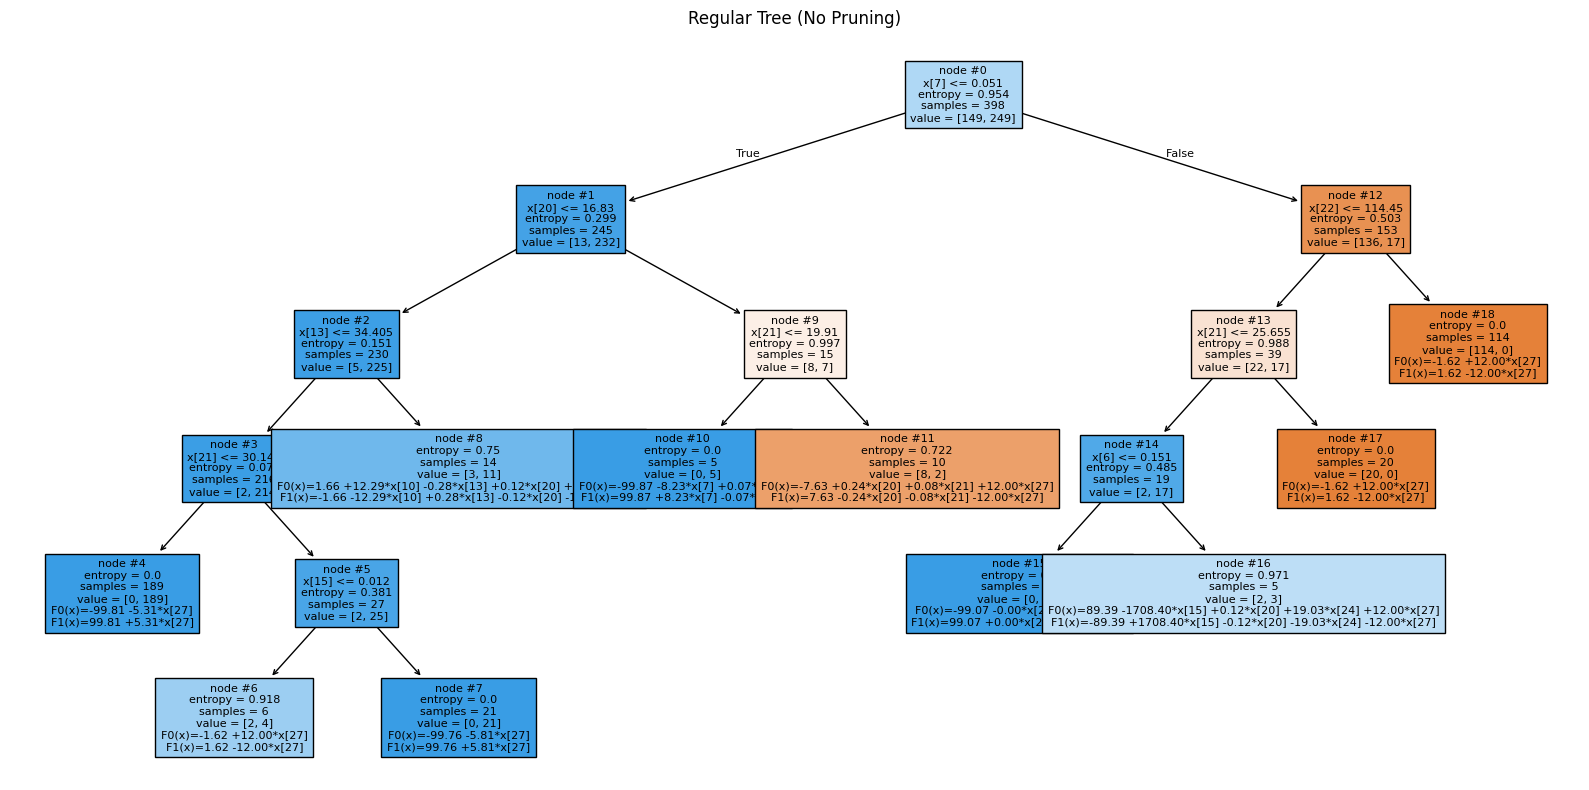

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

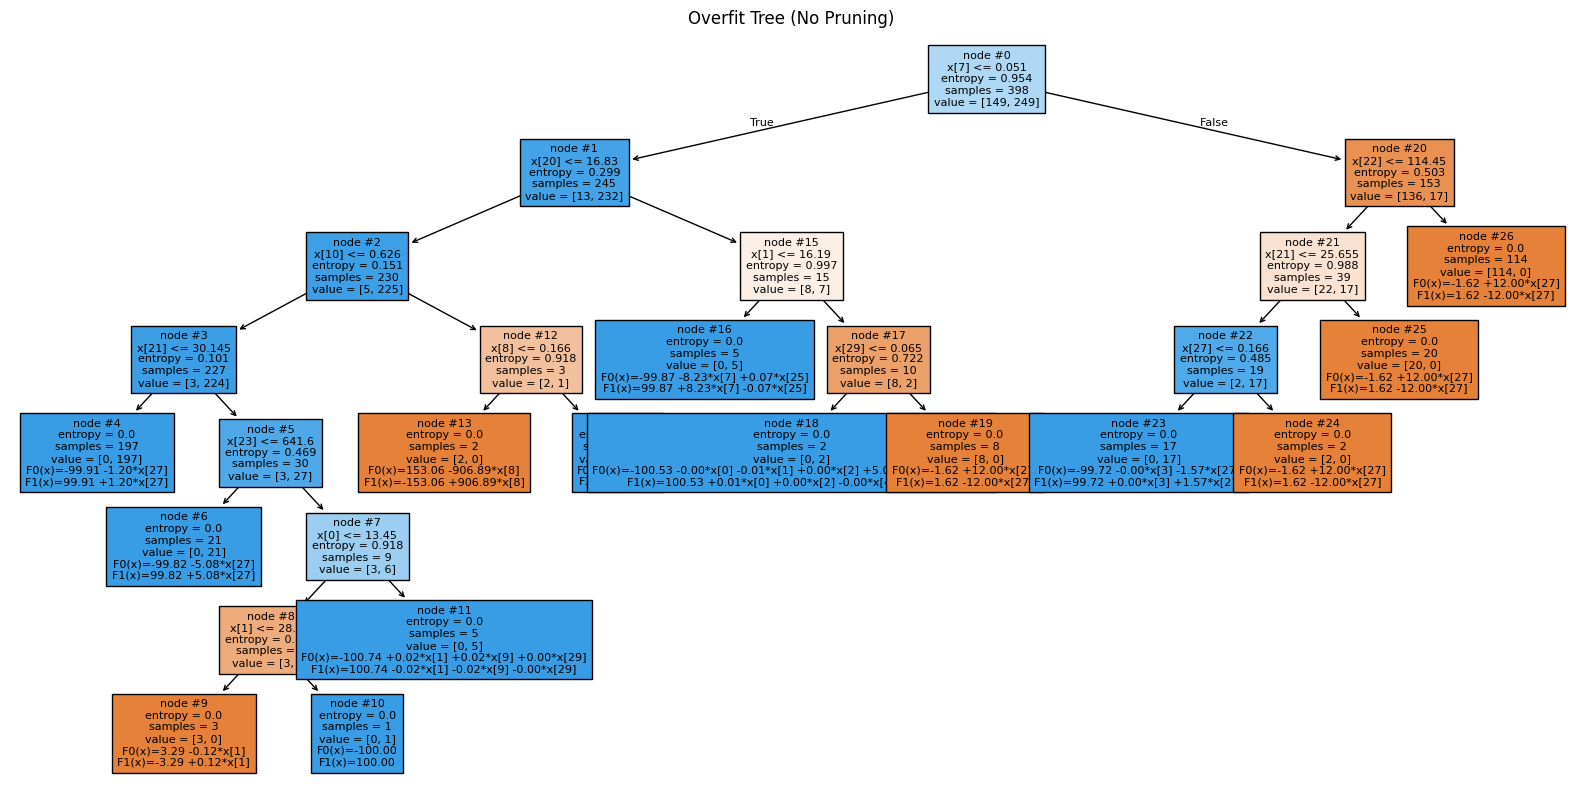

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

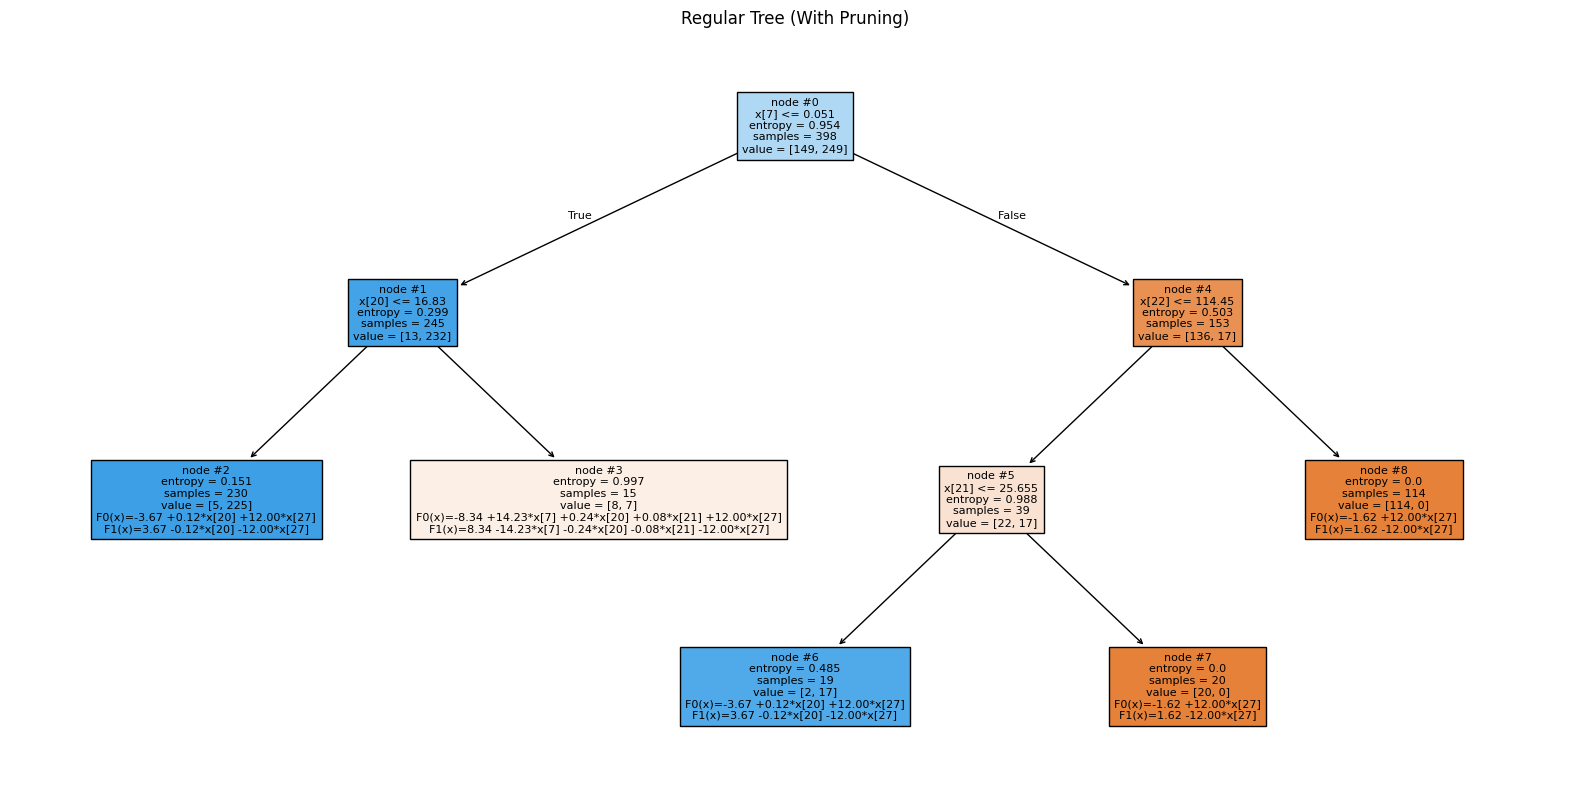

<Figure size 640x480 with 0 Axes>

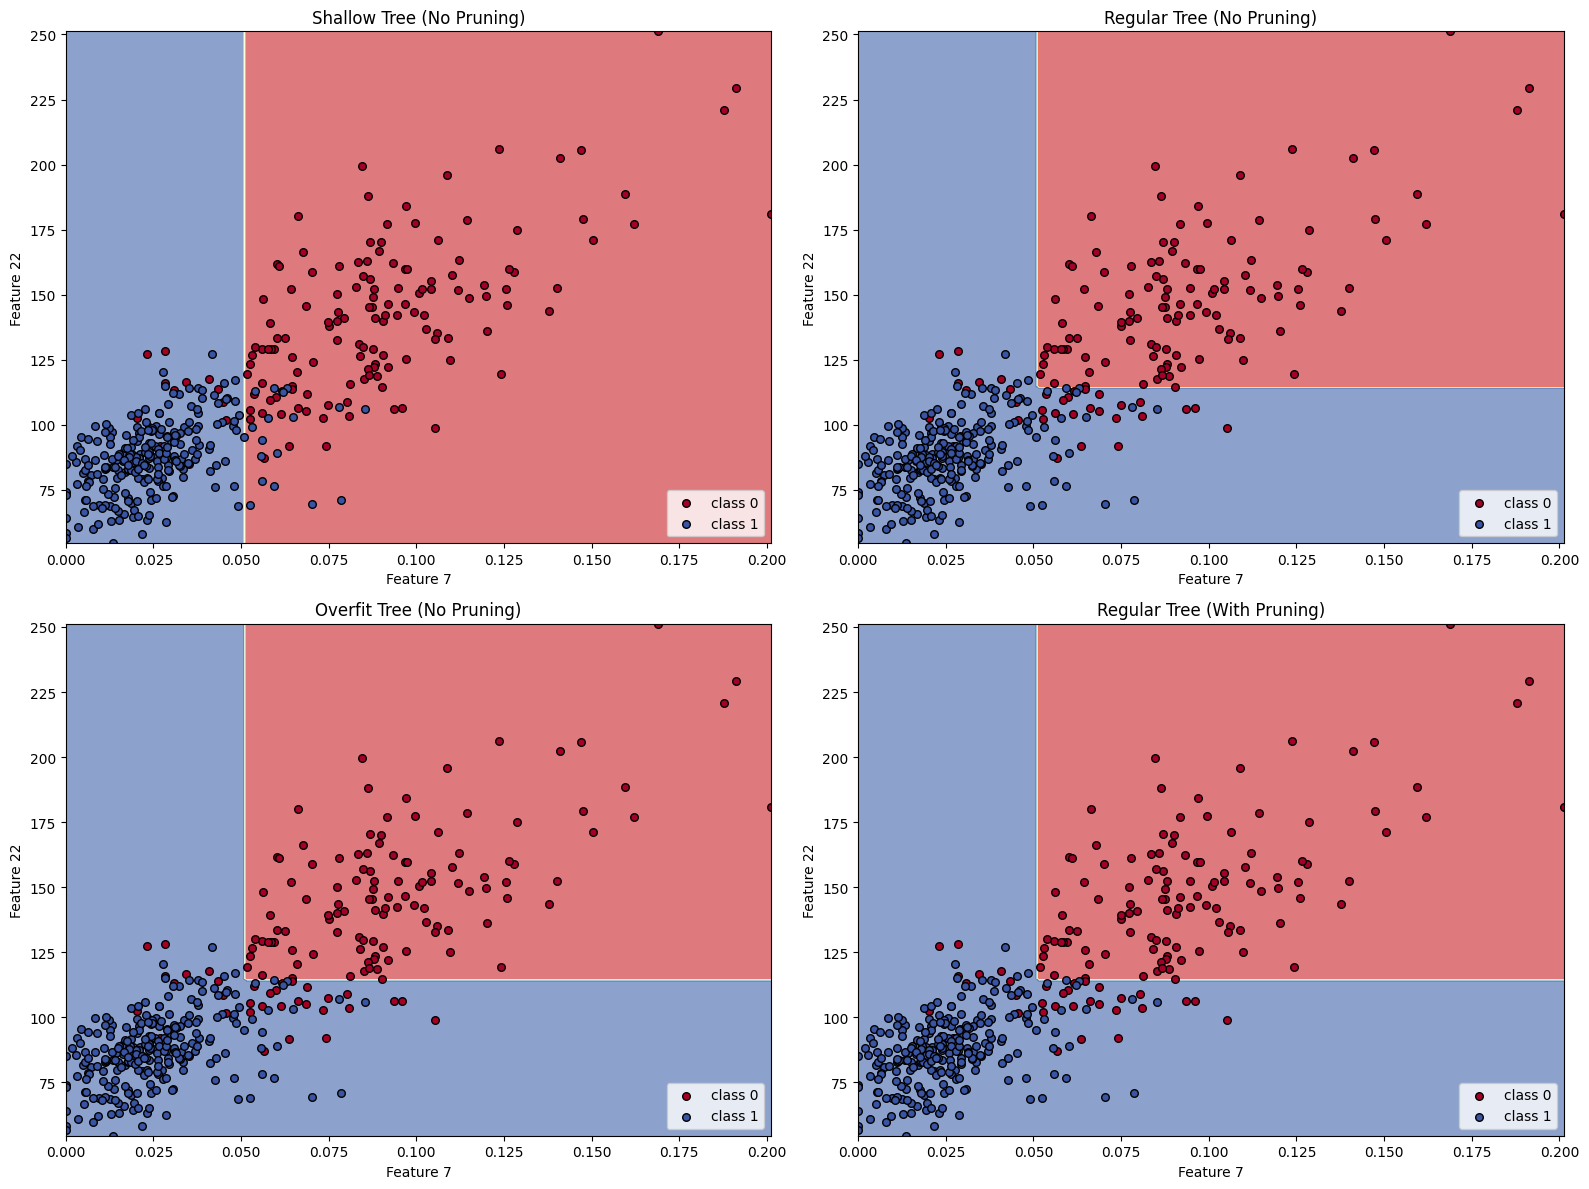

In [19]:
compare_lmt_variants(X_train, X_test, y_train, y_test, lmt)

### Calibration

In [18]:
clf_shallow, nodes_shallow     = lmt.fit_logistic_model_tree(X_train,     y_train,     size='shallow', pruning=False)
clf_regular, nodes_regular     = lmt.fit_logistic_model_tree(X_train,     y_train,     size='regular', pruning=False)
clf_overfit, nodes_overfit     = lmt.fit_logistic_model_tree(X_train,     y_train,     size='overfit', pruning=False)
clf_pruned, nodes_pruned      = lmt.fit_logistic_model_tree(X_train,     y_train,     size='regular', pruning=True)

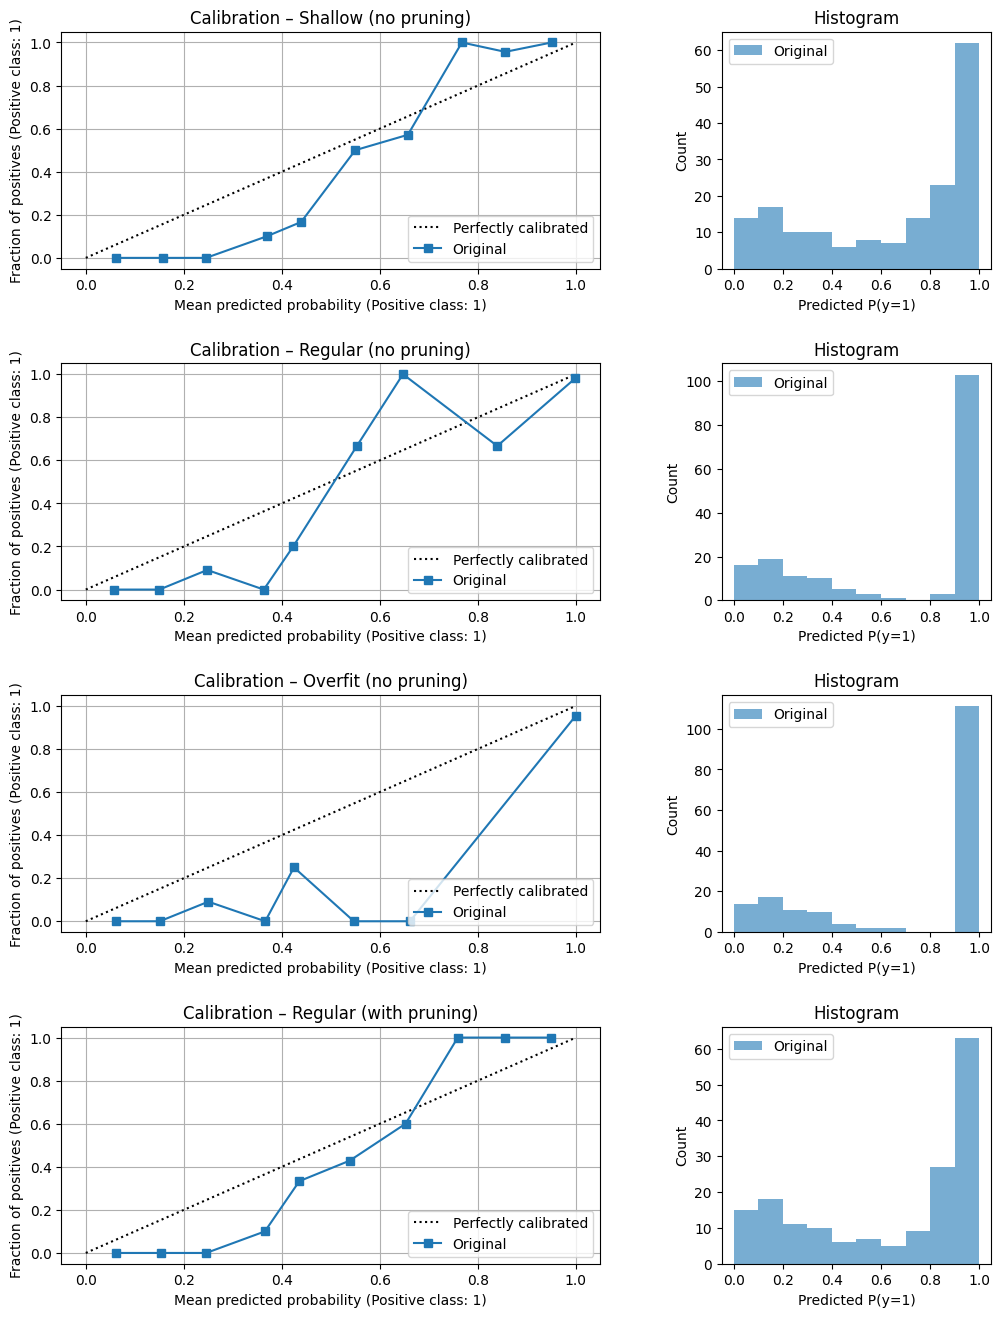

In [19]:
clfs       = [clf_shallow,     clf_regular,     clf_overfit,     clf_pruned]
nodes      = [nodes_shallow,   nodes_regular,   nodes_overfit,   nodes_pruned]
titles     = [
    "Shallow (no pruning)",
    "Regular (no pruning)",
    "Overfit (no pruning)",
    "Regular (with pruning)"
]

fig = plt.figure(figsize=(12, 16))
gs  = GridSpec(4, 2, width_ratios=[2,1], hspace=0.4, wspace=0.3)

for i, title in enumerate(titles):
    ax_curve = fig.add_subplot(gs[i, 0])
    ax_hist  = fig.add_subplot(gs[i, 1])

    # original
    p_orig = lmt.predict_proba_lmt(X_test,     clfs[i],     nodes[i])
    # extended

    CalibrationDisplay.from_predictions(y_test,    p_orig, n_bins=10,
                                        name="Original", ax=ax_curve)
    ax_curve.set_title(f"Calibration – {title}")
    ax_curve.grid(True)

    ax_hist.hist(p_orig, bins=10, range=(0,1), alpha=0.6, label="Original")
    ax_hist.set_title("Histogram")
    ax_hist.set_xlabel("Predicted P(y=1)")
    ax_hist.set_ylabel("Count")
    ax_hist.legend()

plt.show()

In [20]:
from collections import defaultdict

# 1) Assemble your models into one list of (name, clf_tree, node_models, X_te, y_te)
labels = [
    "Shallow tree - No pruning",
    "Regular tree - No pruning",
    "Overfit tree - No pruning",
    "Regular tree - With pruning"
]

orig_models = [
    (f"{label} (original)", clf,   nodes,   X_test,     y_test)
    for label, clf, nodes in zip(
        labels,
        [clf_shallow, clf_regular, clf_overfit, clf_pruned],
        [nodes_shallow, nodes_regular, nodes_overfit, nodes_pruned]
    )
]

all_models = orig_models

# 2) Compute metrics
scores = defaultdict(list)

for name, clf_tree, node_models, X_te, y_te in all_models:
    # leaf‐wise probabilities & predictions
    y_prob = lmt.predict_proba_lmt(X_te, clf_tree, node_models)
    y_pred = lmt.predict_lmt(     X_te, clf_tree, node_models)

    scores["Classifier"].append(name)

    # probabilistic metrics
    for metric in (brier_score_loss, log_loss, roc_auc_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_prob))

    # discrete‐prediction metrics
    for metric in (precision_score, recall_score, f1_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_pred))

# 3) Build DataFrame
tree_score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(4)
)

print(tree_score_df)


                                        Brier  loss  Log loss  Roc auc   \
Classifier                                                                
Shallow tree - No pruning (original)         0.0582    0.2229    0.9882   
Regular tree - No pruning (original)         0.0437    0.5392    0.9791   
Overfit tree - No pruning (original)         0.0599    1.1622    0.9565   
Regular tree - With pruning (original)       0.0493    0.2003    0.9941   

                                        Precision   Recall      F1   
Classifier                                                           
Shallow tree - No pruning (original)        0.9298   0.9815  0.9550  
Regular tree - No pruning (original)        0.9636   0.9815  0.9725  
Overfit tree - No pruning (original)        0.9217   0.9815  0.9507  
Regular tree - With pruning (original)      0.9459   0.9722  0.9589  


## LMT implementation version with *SimpleLogistic* routine just at the root node

### For the original dataset

In [21]:
def compare_lmt_variants_v2(X_train, X_test, y_train, y_test, lmt):
    """
    Trains and evaluates four logistic model trees using different sizes and pruning strategies.
    Plots the tree structure and prints evaluation metrics.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame or np.ndarray
        Training and test feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Training and test labels.
    lmt : module or object
        Module or object that provides the `construct_tree` method.
    """
    
    configs = [
        ('shallow', False, "Shallow Tree (No Pruning)"),
        ('regular', False, "Regular Tree (No Pruning)"),
        ('overfit', False, "Overfit Tree (No Pruning)"),
        ('regular', True,  "Regular Tree (With Pruning)")
    ]

    fitted = []

    # Tree construction
    for size, pruning, label in configs:
        clf_tree, node_models = lmt.fit_logistic_model_tree_v2(X_train, y_train, size=size, pruning=pruning)
        #print(node_models)
        # Hard predictions
        y_pred = lmt.predict_lmt(X_test, clf_tree, node_models)
        # 3) extract per‐sample proba. of class 1
        leaf_ids = clf_tree.apply(X_test)
        proba = []
        for x_i, leaf in zip(X_test, leaf_ids):
            learners = node_models[leaf]['learners']
            J        = node_models[leaf]['J']
            # returns [[p(class=0), p(class=1)]] 
            p01 = lmt.logitboost.logitboost_predict_proba(
                x_i.reshape(1, -1), learners, J
            )
            proba.append(p01[0, 1])
        y_prob = np.array(proba)

        # 4) metrics
        acc  = accuracy_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_prob)
        loss = log_loss(y_test, y_prob)
        print(f"{label} → Accuracy: {acc:.4f}, AUC: {auc:.4f}, Log Loss: {loss:.4f}")
        
        fitted.append((clf_tree, node_models, label))

    # Plotting all four trees
    for clf_tree, node_models, label in fitted:
        plt.figure(figsize=(16, 8))
        lmt.plot_tree_with_linear_models(
            clf_tree, node_models,
            X=X_train,
            title=label
        )
        plt.tight_layout()
        plt.show()

    # Plotting decision surfaces of all four trees
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    for ax, (size, pruning, label) in zip(axes2.ravel(), configs):
        lmt.plot_tree_decision_surface(
            X_train, y_train,
            feature_pair=(0, 1),
            size=size,
            pruning=pruning,
            ax=ax
        )
    plt.tight_layout()
    plt.show()



Shallow Tree (No Pruning) → Accuracy: 0.9591, AUC: 0.9969, Log Loss: 0.0759
Regular Tree (No Pruning) → Accuracy: 0.9532, AUC: 0.9652, Log Loss: 0.5516
Overfit Tree (No Pruning) → Accuracy: 0.9591, AUC: 0.9734, Log Loss: 0.4056
Regular Tree (With Pruning) → Accuracy: 0.9591, AUC: 0.9655, Log Loss: 0.2643


<Figure size 1600x800 with 0 Axes>

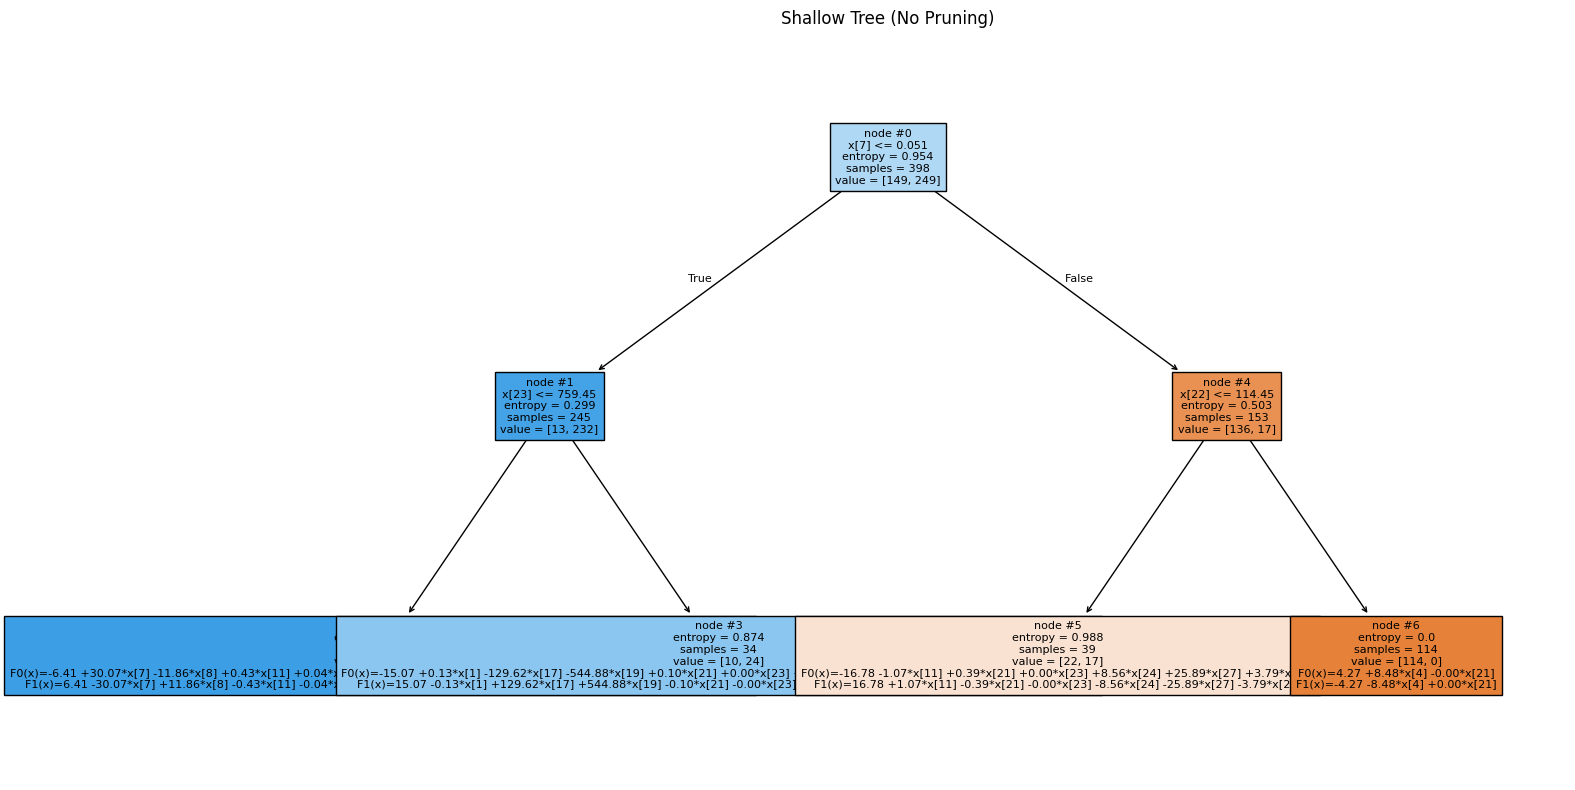

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

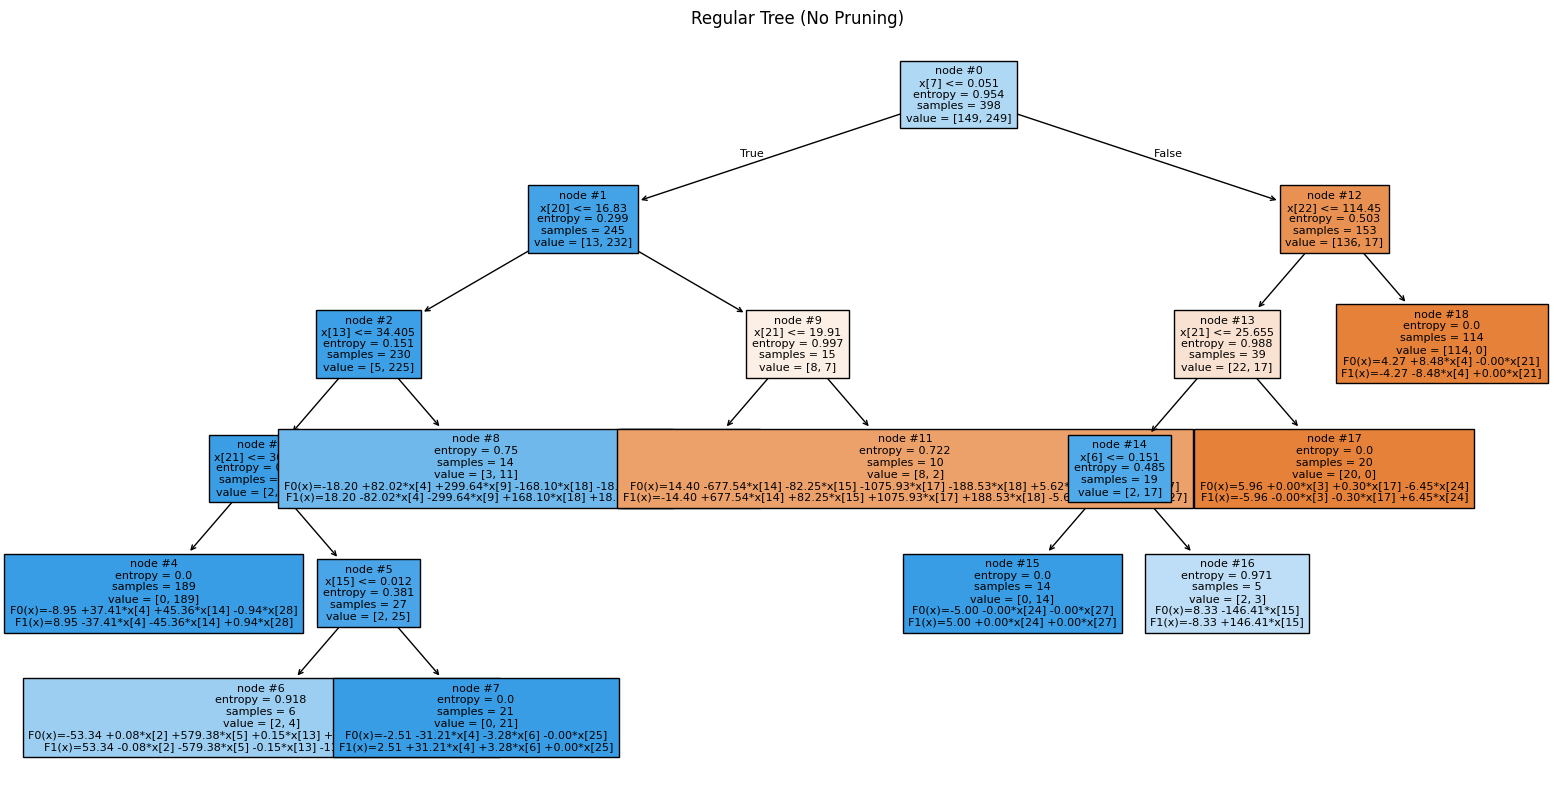

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

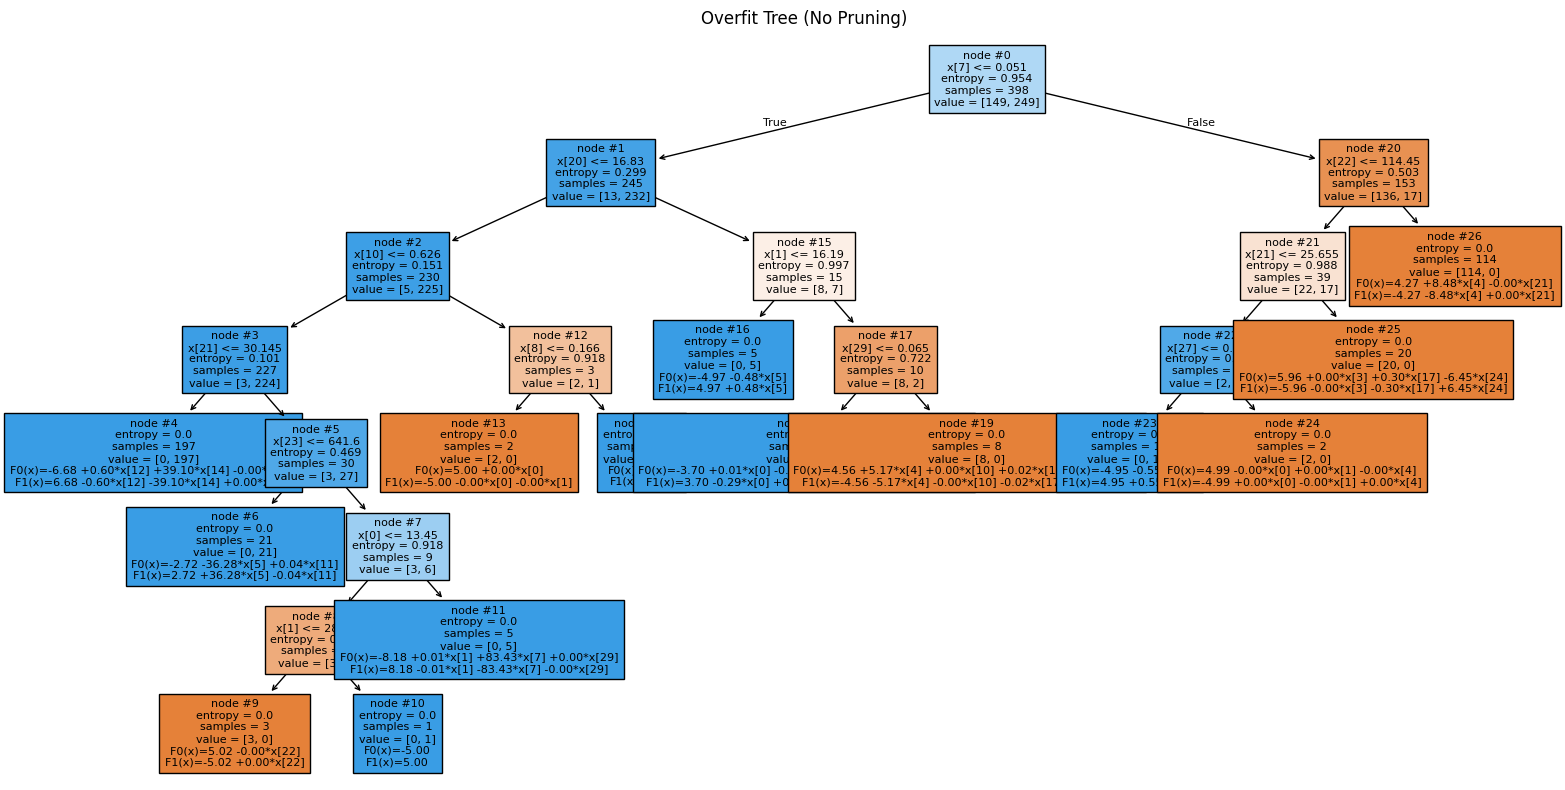

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

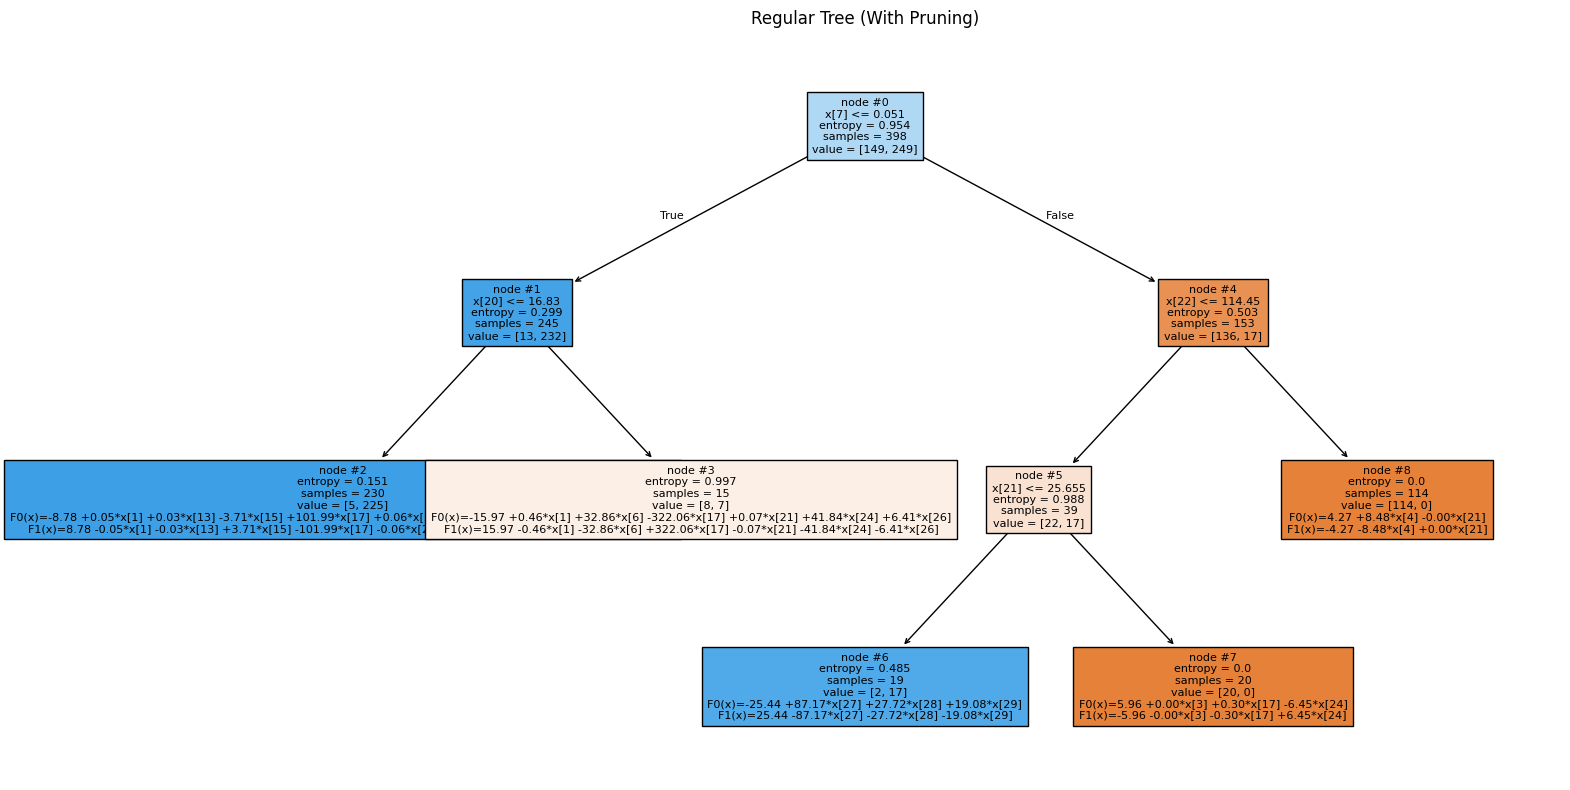

<Figure size 640x480 with 0 Axes>

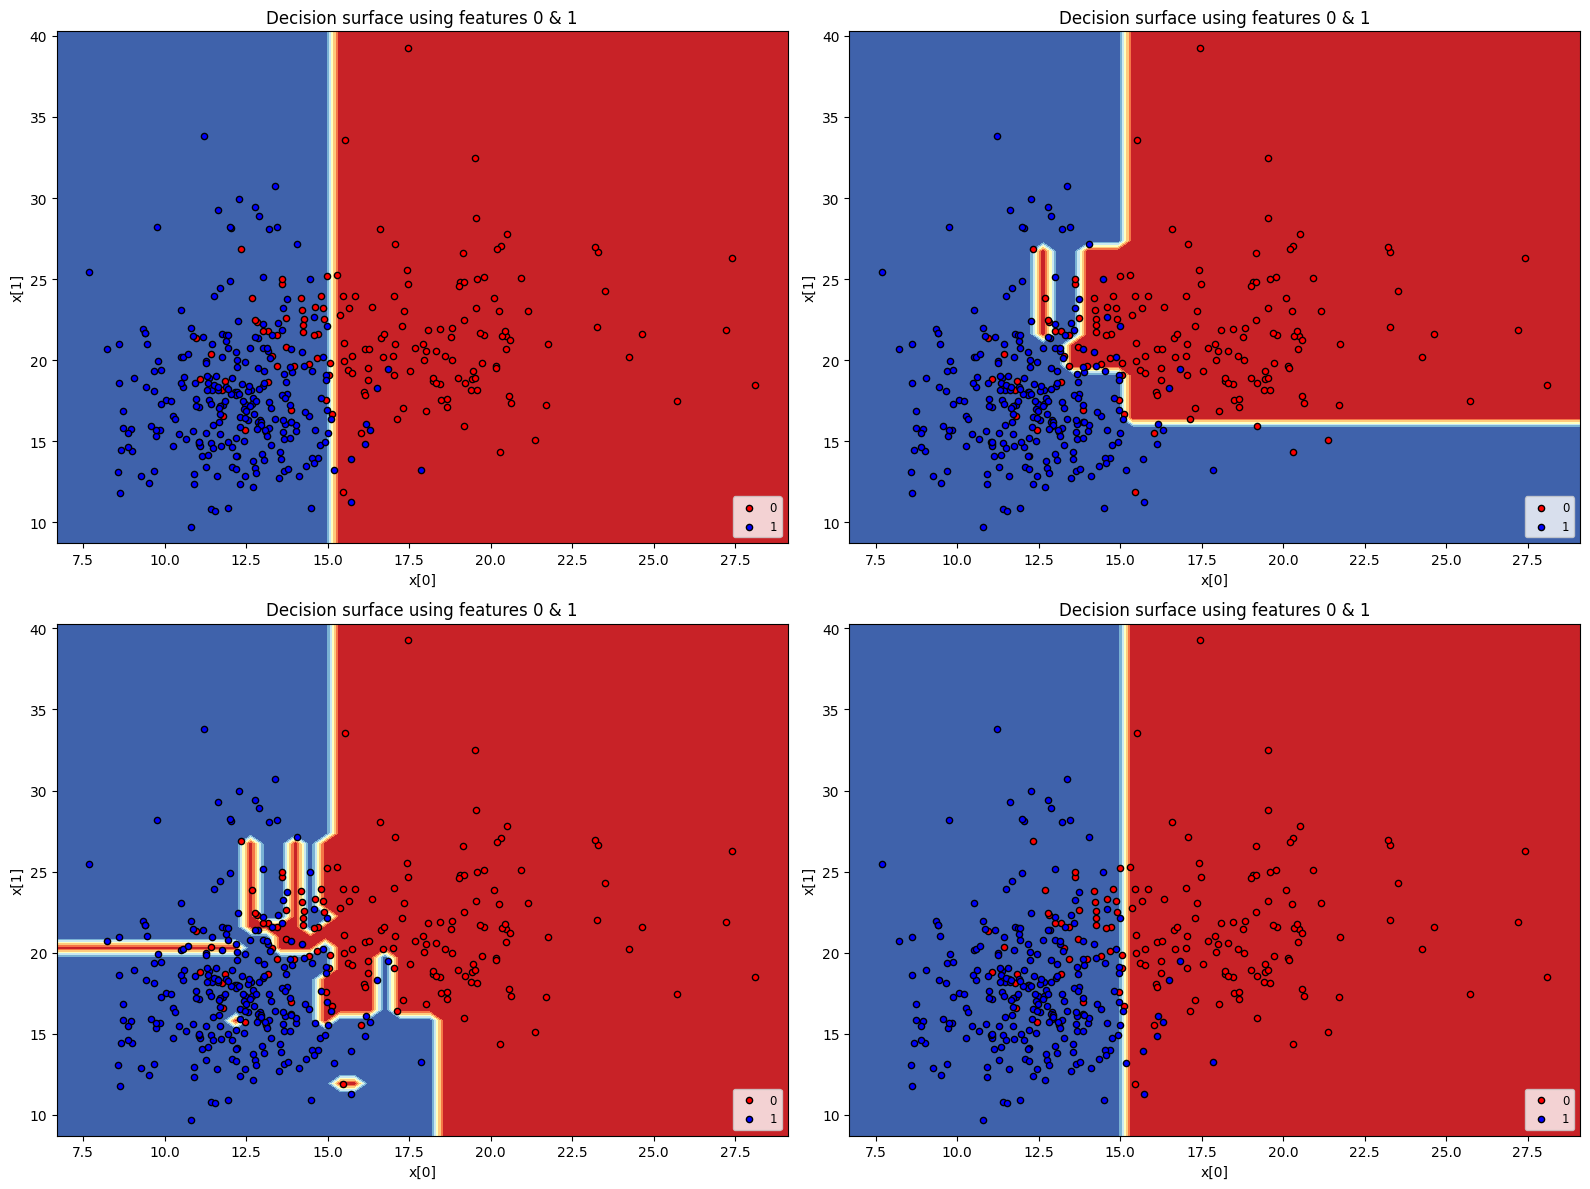

In [22]:
compare_lmt_variants_v2(X_train, X_test, y_train, y_test, lmt)

### Calibration

In [23]:
clf_shallow, nodes_shallow     = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='shallow', pruning=False)
clf_regular, nodes_regular     = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='regular', pruning=False)
clf_overfit, nodes_overfit     = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='overfit', pruning=False)
clf_pruned, nodes_pruned      = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='regular', pruning=True)

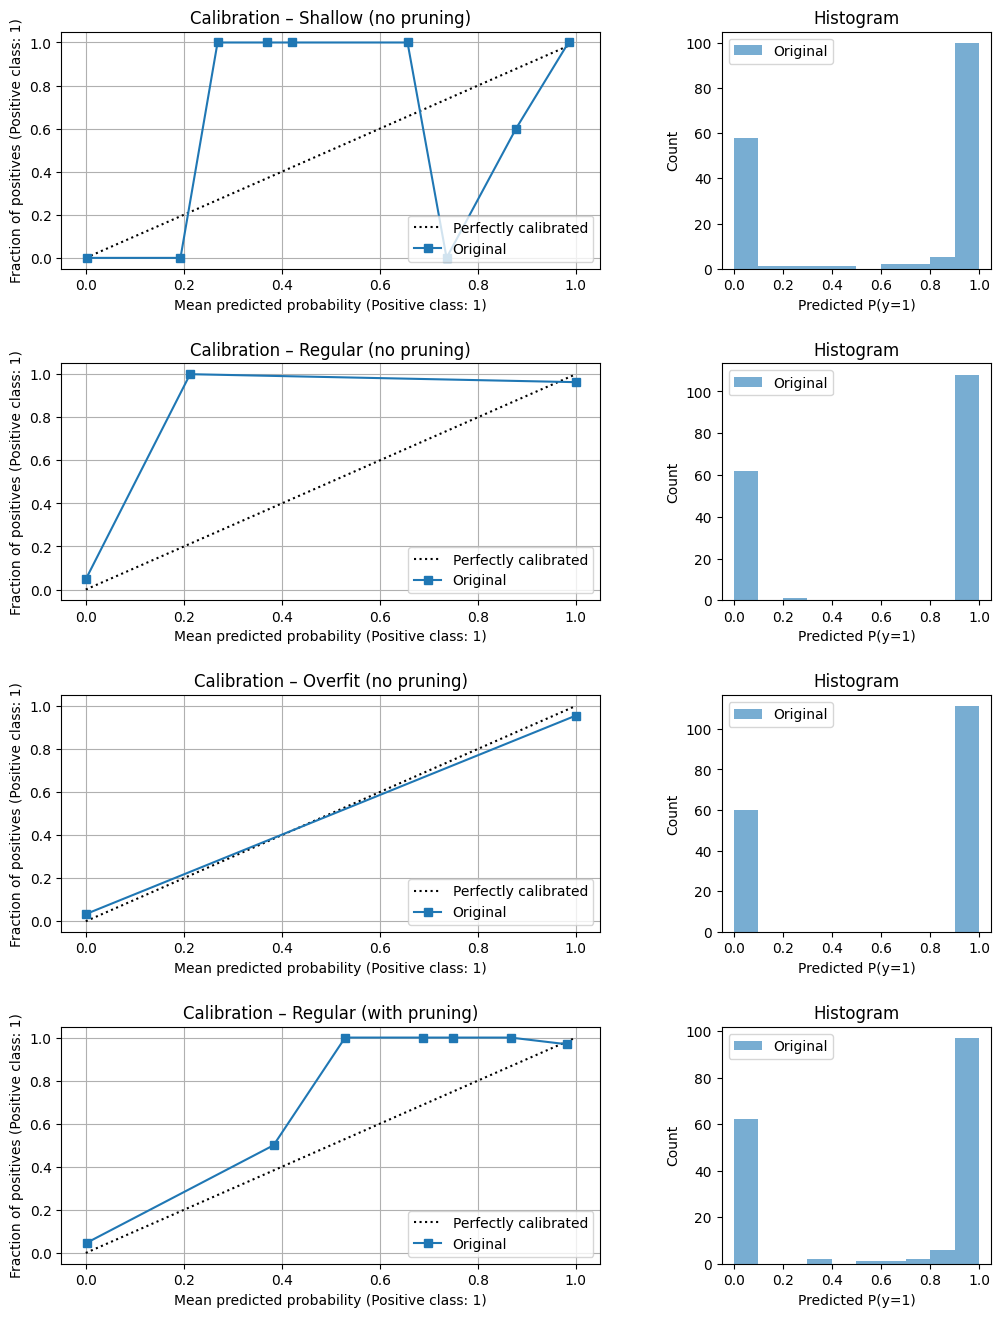

In [24]:
clfs       = [clf_shallow,     clf_regular,     clf_overfit,     clf_pruned]
nodes      = [nodes_shallow,   nodes_regular,   nodes_overfit,   nodes_pruned]
titles     = [
    "Shallow (no pruning)",
    "Regular (no pruning)",
    "Overfit (no pruning)",
    "Regular (with pruning)"
]

fig = plt.figure(figsize=(12, 16))
gs  = GridSpec(4, 2, width_ratios=[2,1], hspace=0.4, wspace=0.3)

for i, title in enumerate(titles):
    ax_curve = fig.add_subplot(gs[i, 0])
    ax_hist  = fig.add_subplot(gs[i, 1])

    # original
    p_orig = lmt.predict_proba_lmt(X_test,     clfs[i],     nodes[i])
    # extended

    CalibrationDisplay.from_predictions(y_test,    p_orig, n_bins=10,
                                        name="Original", ax=ax_curve)
    ax_curve.set_title(f"Calibration – {title}")
    ax_curve.grid(True)

    ax_hist.hist(p_orig, bins=10, range=(0,1), alpha=0.6, label="Original")
    ax_hist.set_title("Histogram")
    ax_hist.set_xlabel("Predicted P(y=1)")
    ax_hist.set_ylabel("Count")
    ax_hist.legend()

plt.show()

In [25]:
# 1) Assemble your models into one list of (name, clf_tree, node_models, X_te, y_te)
labels = [
    "Shallow tree - No pruning",
    "Regular tree - No pruning",
    "Overfit tree - No pruning",
    "Regular tree - With pruning"
]

orig_models = [
    (f"{label} (original)", clf,   nodes,   X_test,     y_test)
    for label, clf, nodes in zip(
        labels,
        [clf_shallow, clf_regular, clf_overfit, clf_pruned],
        [nodes_shallow, nodes_regular, nodes_overfit, nodes_pruned]
    )
]

all_models = orig_models

# 2) Compute metrics
scores = defaultdict(list)

for name, clf_tree, node_models, X_te, y_te in all_models:
    # leaf‐wise probabilities & predictions
    y_prob = lmt.predict_proba_lmt(X_te, clf_tree, node_models)
    y_pred = lmt.predict_lmt(     X_te, clf_tree, node_models)

    scores["Classifier"].append(name)

    # probabilistic metrics
    for metric in (brier_score_loss, log_loss, roc_auc_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_prob))

    # discrete‐prediction metrics
    for metric in (precision_score, recall_score, f1_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_pred))

# 3) Build DataFrame
tree_score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(4)
)

print(tree_score_df)

                                        Brier  loss  Log loss  Roc auc   \
Classifier                                                                
Shallow tree - No pruning (original)         0.0248    0.0759    0.9969   
Regular tree - No pruning (original)         0.0445    0.5516    0.9652   
Overfit tree - No pruning (original)         0.0409    0.4056    0.9734   
Regular tree - With pruning (original)       0.0395    0.2643    0.9655   

                                        Precision   Recall      F1   
Classifier                                                           
Shallow tree - No pruning (original)        0.9633   0.9722  0.9677  
Regular tree - No pruning (original)        0.9630   0.9630  0.9630  
Overfit tree - No pruning (original)        0.9550   0.9815  0.9680  
Regular tree - With pruning (original)      0.9720   0.9630  0.9674  
